In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import pandas as pd
from scipy.spatial import distance

In [2]:
def load_initial(name):
    n_nodes = int(''.join(i for i in name if i.isdigit()))
    nodes = np.loadtxt(f"TSP/{name}.tsp.txt", skiprows = 6, max_rows = n_nodes)
    opt_tour = np.loadtxt(f"TSP/{name}.opt.tour.txt", skiprows = 5, max_rows = n_nodes)

    d_nodes = {}
    for node in nodes: 
        d_nodes[node[0]] = (node[1], node[2])

    return d_nodes, opt_tour

def plotnodes(nodes): 
    plt.figure(figsize = (9,9))

    for node, coordinates in nodes.items():
        plt.plot(coordinates[0], coordinates[1], 'ro')
        plt.annotate(int(node), (coordinates[0], coordinates[1]))

def plotedges(d_nodes, tour):
    x_route = [d_nodes[tour[0]][0]]
    y_route = [d_nodes[tour[0]][1]]

    for node in reversed(tour):
        x_route.append(d_nodes[node][0])
        y_route.append(d_nodes[node][1])

    plt.plot(x_route, y_route, color = 'grey')

def tour_length(d_nodes, tour):
    total_length = 0
    n_nodes = len(d_nodes)

    for i, node in enumerate(tour):
        x1 = d_nodes[node][0]
        y1 = d_nodes[node][1]
        x2 = d_nodes[tour[(i+1)%n_nodes]][0]
        y2 = d_nodes[tour[(i+1)%n_nodes]][1]
        
        total_length += math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return total_length

length = 429.98331198338406


<Figure size 1080x648 with 0 Axes>

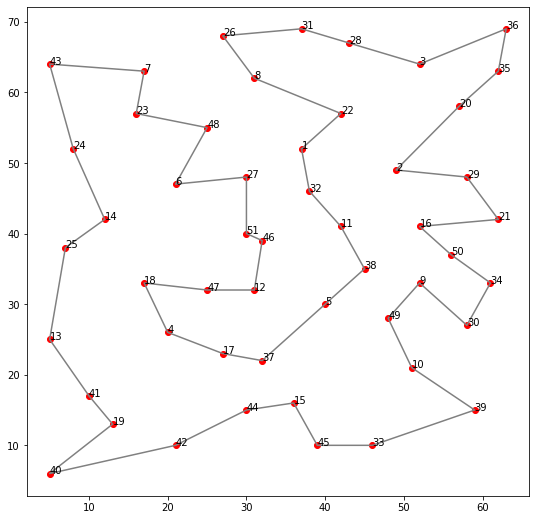

In [3]:
initial = load_initial("eil51")
plt.figure(figsize = (15,9))
plotnodes(initial[0])
plotedges(initial[0], initial[1])
print('length = ' + str(tour_length(initial[0], initial[1])))

In [4]:
def make_distance_matrix(d_nodes):
    n_nodes = len(d_nodes)
    distance_matrix = np.zeros((n_nodes,n_nodes))
    
    for node1 in range(n_nodes):
        for node2 in range(n_nodes):
            x1 = d_nodes[node1+1][0]
            x2 = d_nodes[node2+1][0]
            y1 = d_nodes[node1+1][1]
            y2 = d_nodes[node2+1][1]

            distance_matrix[node1, node2] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    return distance_matrix
    
def matrix_tour_length(tour, distance_matrix):
    total_distance = 0

    for i in range(len(tour)): 
        total_distance += distance_matrix[int(tour[i] - 1), int(tour[(i+1)%len(tour)] - 1)]
        
    return total_distance

def make_random_route(n_nodes):
    l_nodes = np.arange(1,n_nodes+1)
    return list(np.random.permutation(l_nodes))

In [6]:
def lin2opt(old_tour, dist): 
    # apply lin 2 opt to tour
    
    # making sure there are at least two nodes between the two random nodes,
    # otherwise reversing the subtour has no effect
    while True:
        i, j = random.sample(range(len(old_tour)), 2)
        
        if (len(old_tour) + j - i)%len(old_tour) >= 3:
            break
    
    if i < j:
        new_tour = old_tour[:]
        new_tour[i + 1 : j] = new_tour[j - 1 : i : -1]
    else:
        # i > j is also a necessary scenario, but that means reversing the subtour
        # "around" the end and start of the tour list, which is more complicated
        new_tour = []
        
        extra = i + j - len(old_tour)
        if extra >= 0:
            new_tour += old_tour[extra : : -1]
        new_tour += old_tour[i + j : i : -1]
        new_tour += old_tour[j : i + 1]
        new_tour += old_tour[j - 1 : extra : -1]
        if extra < 0:
            if j > 0:
                new_tour += old_tour[j - 1 : : -1]
            new_tour += old_tour[ : len(new_tour) - 1 : -1]

    # calculate the difference in cost only for the changed edges, not the entire tour (saves a lot of time)
    cost_diff = ((dist[new_tour[i] - 1, new_tour[(i+1)%len(new_tour)] - 1] + dist[new_tour[j-1] - 1, new_tour[j] - 1])
                -(dist[old_tour[i] - 1, old_tour[(i+1)%len(old_tour)] - 1] + dist[old_tour[j-1] - 1, old_tour[j] - 1]))
    
    return new_tour, cost_diff

def move_node(old_tour, dist):
    new_tour = old_tour[:]
    
    i, j = random.sample(range(len(new_tour)), 2)
    new_tour.insert(i, new_tour.pop(j))

    # calculate the difference in cost only for the changed edges, not the entire tour (saves a lot of time)
    cost_offset = i < j
    cost_diff = ((dist[new_tour[i-1] - 1, new_tour[i] - 1] + dist[new_tour[i] - 1, new_tour[(i+1)%len(new_tour)] - 1] + dist[new_tour[j-1 + cost_offset] - 1, new_tour[(j + cost_offset)%len(new_tour)] - 1])
                -(dist[old_tour[j-1] - 1, old_tour[j] - 1] + dist[old_tour[j] - 1, old_tour[(j+1)%len(old_tour)] - 1] + dist[old_tour[i - cost_offset] - 1, old_tour[(i + 1 - cost_offset)%len(old_tour)] - 1]))

    return new_tour, cost_diff

In [7]:
def simulated_annealing(nodes, initial_tour, markov_chains, markov_length, initial_temp, cool_rate):
    tour = initial_tour
    temp = initial_temp

    distance_matrix = make_distance_matrix(nodes)

    # for plotting the costs per iteration
    costs = [matrix_tour_length(initial_tour, distance_matrix)]

    for i in range(markov_chains):
        print('\r', f"{i} out of {markov_chains}", end='')

        for _ in range(markov_length):
            if random.random() < 0.5:    
                new_tour, cost_diff = move_node(tour, distance_matrix)
            else:
                new_tour, cost_diff = lin2opt(tour, distance_matrix)

            # e^710 is too big to handle
            accept_prob = math.exp(min(709, -(cost_diff)/temp))

            if accept_prob >= 1 or random.random() <= accept_prob:
                tour = new_tour
                new_cost = costs[-1] + cost_diff
                costs.append(new_cost)
            else:
                costs.append(costs[-1])
        temp *= cool_rate
    print('\n')
    # plt.plot(range(len(costs)), costs)
    # plt.show()

    return tour, costs

 499 out of 500

Length of found route: 438.687474324134
[51, 27, 6, 48, 8, 26, 7, 23, 43, 24, 14, 25, 13, 41, 40, 19, 42, 4, 18, 47, 17, 37, 44, 15, 45, 33, 39, 10, 49, 9, 30, 34, 50, 16, 21, 29, 2, 20, 35, 36, 3, 28, 31, 22, 1, 32, 11, 38, 5, 12, 46]


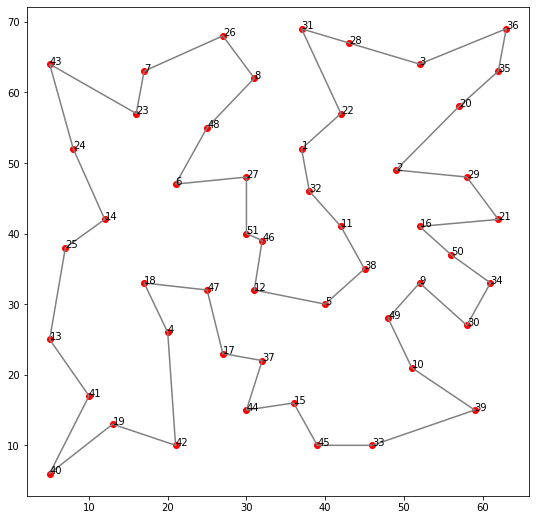

In [8]:

nodes = load_initial("eil51")[0]
distance_matrix = make_distance_matrix(nodes)
annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), 500, 500, 100, 0.975)[0]
plotnodes(nodes)
plotedges(nodes, annealed_tour)
print(f"Length of found route: {matrix_tour_length(nodes, annealed_tour)}")
print(annealed_tour)

 499 out of 500

280
Length of found route: 2967.290354820208


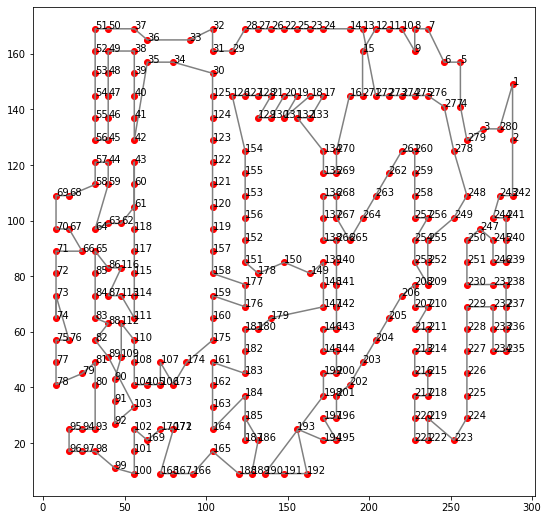

In [9]:
nodes = load_initial("a280")[0]
annealed_tour = simulated_annealing(nodes, make_random_route(len(nodes)), 500, 500, 1000, 0.975)[0]
print(len(annealed_tour))
plotnodes(nodes)
plotedges(nodes, annealed_tour)
print(f"Length of found route: {tour_length(nodes, annealed_tour)}")

In [11]:
# if we wanna save a tour, run this after generating it
with open('TSP_output/eil51_output4.txt', 'w') as f:
    f.write("NAME : ./TSPLIB/a280.tsp.optbc.tour\nCOMMENT : Optimal tour for a280.tsp\nTYPE : TOUR\nDIMENSION : 280\nTOUR_SECTION\n")
    for city in annealed_tour:
        f.write(str(city))
        f.write('\n')

In [12]:

def SA_simulations(nodes, markov_length, iterations, initial_temp, cool_rate, n):
    # determine number of markov chains: total number of iterations should remain the same
    # so if markov chain length is increased, number of markov chains should be lower.

    # Additionally, the cooling rate should be increased so the final temperature is still reached.
    markov_chains = int(iterations/markov_length)
    length_besttour = 10e100

    tours = []
    # save costs per iteration in a markov chain. dictionary should be one longer than range(iterations)
    # because the random initial tour is also saved in the costs list. 
    d_costs = {}
    for i in range(iterations + 1):
        d_costs[i] = []
    
    for i in range(n):
        print(i) 
        
        tour, costs = simulated_annealing(nodes, make_random_route(len(nodes)), markov_chains, markov_length, initial_temp, cool_rate)
        tours.append(tour)
        for j, elem in enumerate(costs):
            d_costs[j].append(elem)
            if elem < length_besttour: 
                length_besttour = elem
                best_tour = tour
    
    return tours, d_costs, best_tour, length_besttour



        



In [13]:

nodes = load_initial("a280")[0]

iterations = 500000
for markov_length in [5000]:
    print(f'markov length = {markov_length} ')
    markov_chains = int(iterations/markov_length)

    tours, d_costs, best_tour, length_besttour = SA_simulations(nodes, markov_length, 500000, 1000, 0.975, 50)

    df = pd.DataFrame.from_dict(d_costs, orient = 'index')
    df.to_csv(f'tsp_simresults/a280_mclength{markov_length}_iterations500000_inittemp1000,coolrate0.975_n50.csv')

    with open(f'tsp_simresults/a280_mclength{markov_length}_iterations500000_inittemp1000,coolrate0.975_n50_bestsol.txt', 'w') as f:
        f.write(f'Best tour = {best_tour}\n')
        f.write(f'Length of best tour = {length_besttour}\n')




markov length = 5000 
0
 99 out of 100

1
 99 out of 100

2
 99 out of 100

3
 99 out of 100

4
 99 out of 100

5
 99 out of 100

6
 58 out of 100

KeyboardInterrupt: 

In [ ]:
# simulated_annealing(nodes, make_random_route(len(nodes)), markov_chains, markov_length, initial_temp, cool_rate)
# SA_simulations(nodes, 500, 500000, 1000, 0.975, 10)
df = pd.DataFrame.from_dict(d_costs, orient = 'index')
df.to_csv('tsp_simresults/a280_mclength100_iterations500000_inittemp1000,coolrate0.972_n10.csv')





In [ ]:

df = pd.read_csv('tsp_simresults/a280_mclength500_iterations500000_inittemp1000,coolrate0.975_n50.csv', index_col = 0)


(500001, 50)


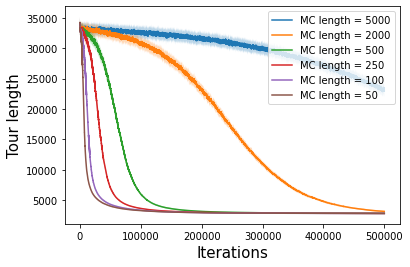

In [76]:
# plotting

for markov_length in [5000, 2000, 500, 250, 100, 50]:



    df = pd.read_csv(f'tsp_simresults/a280_mclength{markov_length}_iterations500000_inittemp1000,coolrate0.975_n50.csv', index_col = 0)


    costs_mean = df.mean(axis = 1)
    costs_std = df.std(axis = 1)

    costs_lowerstd = []
    costs_lower95 = []
    costs_upperstd = []
    costs_upper95 = []
    for i, elem in enumerate(costs_mean):
        costs_lowerstd.append(elem - costs_std[i])
        costs_upperstd.append(elem + costs_std[i])
        costs_lower95.append(elem - 1.96*costs_std[i] / np.sqrt(50))
        costs_upper95.append(elem + 1.96*costs_std[i] / np.sqrt(50))

    plt.plot(range(len(costs_mean)), costs_mean, label = f'MC length = {markov_length}' )
    plt.fill_between(range(len(costs_mean)), costs_lowerstd, costs_upperstd, alpha = 0.3)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Iterations', fontsize = 15)
plt.ylabel('Tour length', fontsize = 15)
plt.legend(fontsize = 'medium', loc = 'upper right')
plt.savefig('plots3/fig2.pdf')
plt.show()
    

[2835.73455714]
[2828.63541075]
[2838.57804068]
[2846.99902986]
[3170.09135946]
{50: array([[2792.496873  , 2906.38970868, 2926.79090719, 2836.16739618,
        2895.94923528, 2838.89539207, 2920.08865696, 2857.06117616,
        2848.48126323, 2854.17255133, 2857.8862428 , 2879.36952429,
        2754.15958398, 2741.390159  , 2918.48473078, 2834.59242508,
        2675.59309762, 2810.63021346, 2846.01087692, 2620.1246238 ,
        2885.78387587, 2817.64704191, 2710.96319678, 2849.94989768,
        2827.46793527, 2766.31877047, 2860.73034552, 2801.47136151,
        2947.60855763, 2823.74772976, 2936.28604698, 2875.04963041,
        2888.20334092, 2896.2134613 , 2779.076584  , 2886.18852275,
        2819.71911281, 2865.96666519, 2890.48153857, 2837.63666053,
        2764.61040727, 2766.40714517, 2904.13647733, 2797.25594047,
        2771.77438234, 2786.39416381, 2822.98843784, 2883.52900137,
        2882.64381507, 2825.74317261]]), 100: array([[2876.54047743, 2874.31692278, 2767.68703487, 

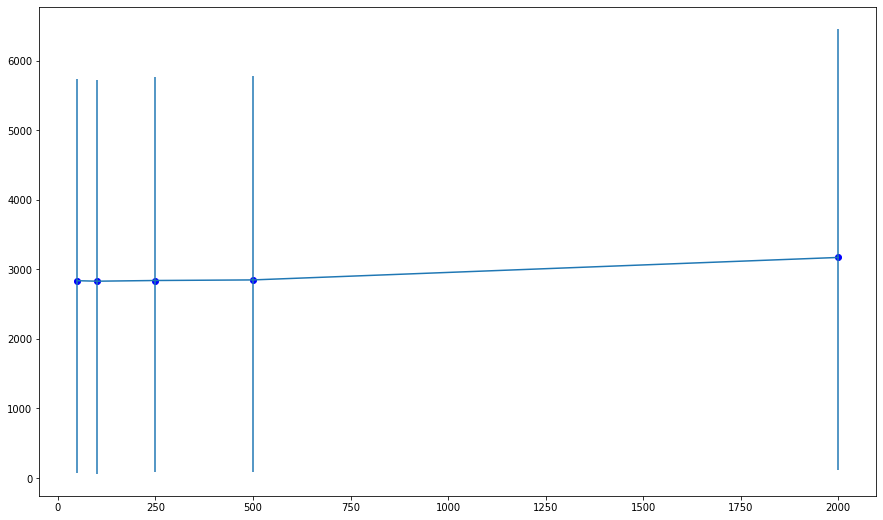

In [ ]:
lengths = [50, 100, 250, 500, 2000]
d_mclengths = {}
means = []
stds = []
for markov_length in [50, 100, 250, 500, 2000]:
    df = pd.read_csv(f'tsp_simresults/a280_mclength{markov_length}_iterations500000_inittemp1000,coolrate0.975_n50.csv', index_col = 0,skiprows = 500000)
    df.columns = np.arange(0,50)
    print(df.values.mean(axis = 1))
    means.append(float(df.values.mean(axis=1)))
    stds.append(float(df.values.std(axis=1)))
    d_mclengths[markov_length] = df.values


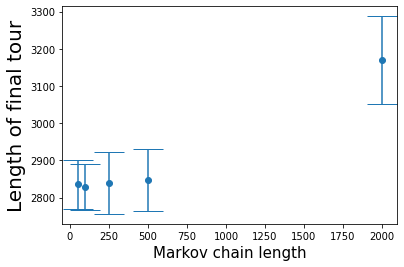

In [73]:

plt.xlabel('Markov chain length', fontsize = 15)
plt.ylabel('Length of final tour', fontsize = 15)
plt.errorbar(lengths, means, yerr = stds, fmt = 'o', capsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig('plots3/fig3.pdf')
plt.show()

In [77]:
# anova tesing
from scipy.stats import f_oneway
print(f' ANOVA of first four groups: {f_oneway(d_mclengths[50][0], d_mclengths[100][0], d_mclengths[250][0], d_mclengths[500][0])[1]}' )

print(f' ANOVA of all five groups: {f_oneway(d_mclengths[50][0], d_mclengths[100][0], d_mclengths[250][0], d_mclengths[500][0], d_mclengths[2000][0])[1]}' )


 ANOVA of first four groups: 0.6719370201215911
 ANOVA of all five groups: 3.819571812083013e-65
